# Bank Term Deposit Prediction Model
### Comparing different machine learning models for predicting subscription to bank term deposit.

Bank has multiple banking products that it sells to customer such as saving account, credit cards, investments like Term Deposit, Recurring Deposit etc. The investment department of the Bank would want to be able to identify their customers who potentially would subscribe to their term deposits. Once it can predict the chances that customer will purchase a product, the marketing managers can carefully tune their directed campaigns to these customer to improve the Bank performance. 

We will do  data cleaning, data exploration,dealing with class imbalance and then figure out a robust machine learning algorithm for predicting the potential customers who would subscribe to the term deposit using different Machine learning library. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report
from sklearn.dummy import DummyClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [2]:
df= pd.read_csv("EDAresults.csv")
df.head()

,Id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed_td
0,1002,44.0,blue-collar,single,secondary,no,29.0,yes,no,unknown,5,may,151,1,-1,0,unknown,no
1,1003,33.0,self-employed,married,secondary,no,2.0,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
2,1004,47.0,blue-collar,married,unknown,no,1506.0,yes,no,unknown,5,may,92,1,-1,0,unknown,no
3,1005,33.0,unknown,single,unknown,no,1.0,no,no,unknown,5,may,198,1,-1,0,unknown,no
4,1006,35.0,white-collar,married,tertiary,no,231.0,yes,no,unknown,5,may,139,1,-1,0,unknown,no


### OneHot Encoding of categorical variables

In [3]:
#duration of the last contact doesn't seem much relevant so let's drop it
df.drop(columns=['duration'],inplace=True)
df.head()

,Id,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,subscribed_td
0,1002,44.0,blue-collar,single,secondary,no,29.0,yes,no,unknown,5,may,1,-1,0,unknown,no
1,1003,33.0,self-employed,married,secondary,no,2.0,yes,yes,unknown,5,may,1,-1,0,unknown,no
2,1004,47.0,blue-collar,married,unknown,no,1506.0,yes,no,unknown,5,may,1,-1,0,unknown,no
3,1005,33.0,unknown,single,unknown,no,1.0,no,no,unknown,5,may,1,-1,0,unknown,no
4,1006,35.0,white-collar,married,tertiary,no,231.0,yes,no,unknown,5,may,1,-1,0,unknown,no


In [4]:
# One hot encoding of categorical columns
cat_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=cat_cols,drop_first=True)

### StandardScaler on Numerical variables

In [5]:
#MinMax Scaler for Numerical Variables
scaler = MinMaxScaler()
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[num_cols] = scaler.fit_transform(df[num_cols])
df.head()

,Id,age,balance,day,campaign,pdays,previous,job_pink-collar,job_retired,job_self-employed,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,subscribed_td_yes
0,0.000000,0.337662,0.073067,0.133333,0.0,0.0,0.0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,0.000022,0.194805,0.072822,0.133333,0.0,0.0,0.0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
2,0.000044,0.376623,0.086476,0.133333,0.0,0.0,0.0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,0.000066,0.194805,0.072812,0.133333,0.0,0.0,0.0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0.000088,0.220779,0.074901,0.133333,0.0,0.0,0.0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


### Separate feature variables and target variable

In [6]:
# Separate feature variables and target variable
X = df.drop(['subscribed_td_yes'], axis = 1)
y = df['subscribed_td_yes']

### Dimensionality Reduction: Principal Component Analysis

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 10)
pca.fit(X)
X_trans = pca.transform(X)

In [8]:
X_transformed = pd.DataFrame(data = X_trans, columns = ['PC_1', 'PC_2','PC_3', 'PC_4','PC_5','PC_6', 'PC_7','PC_8', 'PC_9','PC_10'])
X_transformed

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10
0,-1.053654,1.214534,-0.119424,-0.267461,-0.102366,-0.058228,-0.195180,-0.046584,-0.006647,-0.140751
1,-1.368337,-0.034451,0.481807,-0.040709,0.125025,0.186570,0.007586,0.649887,0.594944,-0.382064
2,-0.906575,0.063902,0.993150,-0.091491,-0.483828,0.219943,-0.165141,0.023193,-0.219618,-0.110426
3,-0.269145,1.031160,0.141090,-0.833826,-0.712334,0.074601,-0.313089,0.483329,-0.445927,-0.154058
4,-0.160970,0.360768,1.624866,0.092483,0.161487,-0.267745,-0.151217,0.033774,-0.101028,0.145467
...,...,...,...,...,...,...,...,...,...,...
45191,0.872170,-0.635090,0.263130,0.005989,-0.460065,0.239547,-0.027563,-0.106736,0.035409,-0.381661
45192,0.571246,-0.234492,-0.453924,-0.192034,-0.539554,0.209488,-0.002773,-0.027939,-0.170709,-0.612916
45193,0.130334,-0.920818,-0.797254,0.551958,-0.601571,-0.474367,0.376088,0.239239,-0.264244,-0.496172
45194,0.021158,-0.892254,-0.656067,0.036496,-0.124709,-0.172281,-0.068179,-0.124502,-0.186413,-0.555406


### Split Data into Train and Test data sets
We are splitting the train and test data in 80:20 ratio.

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=.20, random_state=1)

### Class balancing

In [10]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, make_scorer

# there is a high imbalance in the target class and so there could be bias in the output.
# So class_weight has been made as balanced to balance the class values 
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto', class_weight='balanced'),
        'params' : {
            'C': [1,10,15],
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(class_weight='balanced'),
        'params' : {
            'n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='saga',multi_class='auto', class_weight='balanced'),
        'params': {
            'C': [1,10,15],
            "penalty":["l1","l2"]        
        }
    },
    'knn' : {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [1,3,5,11],
            'weights':['uniform','distance'],
            'metric':['euclidean','manhattan']
        }
    }
}

### Hyperparameter tuning

In [11]:
scores = []

cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 4)

for model_name, mp in model_params.items():
    rs = RandomizedSearchCV(mp['model'], mp['params'],cv=5,return_train_score=False,n_iter=2)
    rs.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': rs.best_score_,
        'best_params': rs.best_params_
    })

# To display all the columns in the dataframe eg. if there are 100 colns all will be displayed
pd.set_option('max_columns', None) 

# To display the column values fully in each cell
pd.set_option('max_colwidth', None)  

comparison_df = pd.DataFrame(scores,columns=['model','best_score','best_params'])

### Best Parameters for Machine Learning Algorithms

In [12]:
# To sort values based on best_score
comparison_df.sort_values(by=['best_score'], inplace=True, ascending=False)
comparison_df

,model,best_score,best_params
3,knn,0.874682,"{'weights': 'uniform', 'n_neighbors': 3, 'metric': 'euclidean'}"
1,random_forest,0.868321,{'n_estimators': 5}
0,svm,0.773675,"{'kernel': 'rbf', 'C': 10}"
2,logistic_regression,0.685834,"{'penalty': 'l1', 'C': 10}"


Comparing all the four machine learning algorithms 

- K_Nearest_Neighbour seems to give the best accuracy for the problem with an accuracy of 88%, 
- Next best is the Random_forest classifier with 87% accuracy
- Third comes the SVM with 77% accuracy
- Finally logistic_regression gives 68% accuracy. 

Let's implement them.

### Machine Learning model Implementation

#### Model implementation and metrics - function

In [13]:
# Displays the performance of each model
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score

def model_implement(model, X, y,cv):

    scores = []
    model_accuracy = ''
    model_log_loss=''
    model_log_loss=''
    
    for train_index,test_index in cv.split(X,y):
        X_train,X_test = X.loc[train_index],X.loc[test_index]
        y_train,y_test = y.loc[train_index],y.loc[test_index]

        # Fit the model on the training data
        model_obj = model.fit(X_train, y_train)
        y_pred = model_obj.predict(X_test)
        
        # Score the model on the validation data
        score = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        scores.append(score)
        mean_score = np.array(scores).mean()
        mean_score = str(round(mean_score, 2))
        model_accuracy ='Accuracy scores of the classifier:'+mean_score
        
#         model_log_loss = log_loss(y_test, y_pred)
#         model_log_loss = str(round(model_log_loss, 3))
        
        model_f1_score = f1_score(y_test, y_pred, average='weighted')
        model_f1_score = str(round(model_f1_score, 2))
    
            
    print(model_accuracy)
    
    model_f1_score ='F1 score of classifier is:'+model_f1_score
    print(model_f1_score)
    
    print('\n Classification report of the model')
    print('--------------------------------------')
    print(report)
    
    print('\n Confusion Matrix of the model')
    print('--------------------------------------')
    print(conf_matrix)
    
    model_accuracy ='Accuracy of classifier is:'+mean_score
    
#     model_log_loss ='Average Log Loss:'+model_log_loss
#     print(model_log_loss)
    return model_accuracy,model_f1_score
  


#### ROC_plot_display_function

In [14]:
# Displays roc plot for each function
import os
my_path = os.path.join(os.path.pardir)

def roc_plot(model, X, y,cv,model_name):
    for train_index,test_index in cv.split(X,y):
        X_train,X_test = X.loc[train_index],X.loc[test_index]
        y_train,y_test = y.loc[train_index],y.loc[test_index]
        model_obj = model.fit(X_train, y_train)
        y_pred = model_obj.predict(X_test)
        y_pred_prob = model_obj.predict_proba(X_test)[:,1]
        
        logit_roc_auc = roc_auc_score(y_test, y_pred)
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
        
    fig = plt.figure()
    fig.set_figwidth(3)
    fig.set_figheight(4)
    plt.plot(fpr, tpr, label=' (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    my_fig = model_name + '.png'
    plt.savefig(os.path.join(my_path, my_fig))
    img_path=os.path.join(my_path, my_fig)
    plt.show()
    return img_path


# Converting image links to html tags
def path_to_image_html(path):
    return '<img src="'+ path + '" width="250" height="150">'

### Model Implementation using best parameters

In [15]:
# Each classifier's best parameters are given by the RandomSearchCV. We use them to create classifier object
model_best_params = {
#     'SVM': {
# #         'model_obj': svm.SVC(gamma='auto', class_weight='balanced',kernel= 'linear', C= 10, probability=True)
#         'model_obj': svm.SVC(probability=True)
#     },
    'Logistic_Regression' : {
        'model_obj': LogisticRegression(penalty='l1',solver='saga',multi_class='auto', class_weight='balanced',C=10)
    },
    'Random_Forest': {
        'model_obj': RandomForestClassifier(class_weight='balanced',n_estimators= 5)
    },
    'K-Nearest_Neighbour' : {
        'model_obj': KNeighborsClassifier(weights= 'uniform', n_neighbors= 5, metric= 'manhattan')
    }
}

Logistic_Regression
Accuracy scores of the classifier:0.69
F1 score of classifier is:0.74

 Classification report of the model
--------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.69      0.79      3991
           1       0.22      0.68      0.33       528

    accuracy                           0.68      4519
   macro avg       0.58      0.68      0.56      4519
weighted avg       0.86      0.68      0.74      4519


 Confusion Matrix of the model
--------------------------------------
[[2737 1254]
 [ 170  358]]


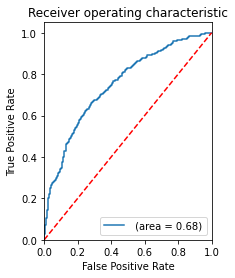

Random_Forest
Accuracy scores of the classifier:0.87
F1 score of classifier is:0.86

 Classification report of the model
--------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      3991
           1       0.39      0.27      0.32       528

    accuracy                           0.87      4519
   macro avg       0.65      0.61      0.62      4519
weighted avg       0.85      0.87      0.86      4519


 Confusion Matrix of the model
--------------------------------------
[[3771  220]
 [ 385  143]]


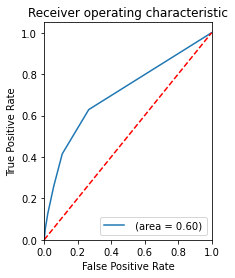

K-Nearest_Neighbour
Accuracy scores of the classifier:0.88
F1 score of classifier is:0.87

 Classification report of the model
--------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      3991
           1       0.50      0.27      0.35       528

    accuracy                           0.88      4519
   macro avg       0.70      0.62      0.64      4519
weighted avg       0.86      0.88      0.87      4519


 Confusion Matrix of the model
--------------------------------------
[[3848  143]
 [ 386  142]]


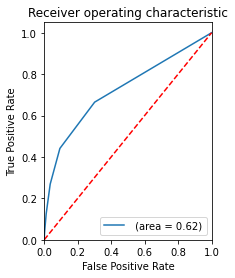

In [16]:
model_performance = []

cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 4)

for model_name, mo in model_best_params.items():
    print("\033[1m" +model_name+ "\033[0m")
    clf_accuracy,clf_f1_score = model_implement(mo['model_obj'], X_transformed, y,cv)
    path = roc_plot(mo['model_obj'], X_transformed, y,cv,model_name)
    
    model_performance.append({
        'Model': model_name,
        'Accuracy': clf_accuracy,
        'F1_Score': clf_f1_score,
        'ROC_AUC_Curve':path
    })

# To display all the columns in the dataframe eg. if there are 100 colns all will be displayed
pd.set_option('max_columns', None) 

# To display the column values fully in each cell
pd.set_option('max_colwidth', None)  

classifier_df = pd.DataFrame(model_performance,columns=['Model','Accuracy','F1_Score','ROC_AUC_Curve'])



### Comparing Classification Algorithms

In [17]:
# Importing the HTML libraries
from IPython.core.display import HTML

# Rendering Images inside a Pandas DataFrame by converting dataframe to html
classifier_df.to_html(escape=False, formatters=dict(ROC_AUC_Curve=path_to_image_html))

# Rendering the images in the dataframe using the HTML method.
HTML(classifier_df.to_html(escape=False, formatters=dict(ROC_AUC_Curve=path_to_image_html)))


,Model,Accuracy,F1_Score,ROC_AUC_Curve
0,Logistic_Regression,Accuracy of classifier is:0.69,F1 score of classifier is:0.74,
1,Random_Forest,Accuracy of classifier is:0.87,F1 score of classifier is:0.86,
2,K-Nearest_Neighbour,Accuracy of classifier is:0.88,F1 score of classifier is:0.87,


Comparing all the classifiers <b> K-Nearest neighbour </b> performs better on the given model as the accuracy is and f1 score is as compared to others. Let's implement the same and get the predictions for the dataset.

In [18]:
# Implementing the best algorithm on the dataset

best_model = KNeighborsClassifier(weights= 'uniform', n_neighbors= 5, metric= 'manhattan')
best_model_object = best_model.fit(X, y)
df['predicted_values'] = best_model_object.predict(X)